In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import tensorflow
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adamax
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam,Adadelta,RMSprop,Adagrad
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import numpy as np
import argparse
import cv2

from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
import scipy
import skimage
from skimage.transform import resize
import random
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/covid-cxr-image-dataset-research/COVID_IEEE/normal/NORMAL2-IM-0771-0001.jpeg
/kaggle/input/covid-cxr-image-dataset-research/COVID_IEEE/normal/IM-0421-0001.jpeg
/kaggle/input/covid-cxr-image-dataset-research/COVID_IEEE/normal/NORMAL2-IM-0531-0001.jpeg
/kaggle/input/covid-cxr-image-dataset-research/COVID_IEEE/normal/NORMAL2-IM-0416-0001-0002.jpeg
/kaggle/input/covid-cxr-image-dataset-research/COVID_IEEE/normal/NORMAL2-IM-0627-0001.jpeg
/kaggle/input/covid-cxr-image-dataset-research/COVID_IEEE/normal/NORMAL2-IM-0757-0001.jpeg
/kaggle/input/covid-cxr-image-dataset-research/COVID_IEEE/normal/NORMAL2-IM-0696-0001.jpeg
/kaggle/input/covid-cxr-image-dataset-research/COVID_IEEE/normal/NORMAL2-IM-0808-0001.jpeg
/kaggle/input/covid-cxr-image-dataset-research/COVID_IEEE/normal/IM-0101-0001.jpeg
/kaggle/input/covid-cxr-image-dataset-research/COVID_IEEE/normal/IM-0304-0001.jpeg
/kaggle/input/covid-cxr-image-dataset-research/COVID_IEEE/normal/NORMAL2-IM-0385-0001.jpeg
/kaggle/input/covi

In [5]:
COV_DIR = "/kaggle/input/covid-cxr-image-dataset-research/COVID_IEEE/covid"
NORM_DIR = "/kaggle/input/covid-cxr-image-dataset-research/COVID_IEEE/normal"
VIR_DIR = "/kaggle/input/covid-cxr-image-dataset-research/COVID_IEEE/virus"

In [6]:
Pimages = os.listdir(COV_DIR)
Nimages = os.listdir(NORM_DIR)
Vimages = os.listdir(VIR_DIR)

In [7]:
def Images_details_Print_data(data, path):
    print(" ====== Images in: ", path)    
    for k, v in data.items():
        print("%s:\t%s" % (k, v))

def Images_details(path):
    files = [f for f in glob.glob(path + "**/*.*", recursive=True)]
    data = {}
    data['images_count'] = len(files)
    data['min_width'] = 10**100  # No image will be bigger than that
    data['max_width'] = 0
    data['min_height'] = 10**100  # No image will be bigger than that
    data['max_height'] = 0


    for f in files:
        im = Image.open(f)
        width, height = im.size
        data['min_width'] = min(width, data['min_width'])
        data['max_width'] = max(width, data['max_height'])
        data['min_height'] = min(height, data['min_height'])
        data['max_height'] = max(height, data['max_height'])

    Images_details_Print_data(data, path)

In [8]:
Images_details(COV_DIR)

 ====== Images in:  /kaggle/input/covid-cxr-image-dataset-research/COVID_IEEE/covid
images_count:	536
min_width:	240
max_width:	4095
min_height:	237
max_height:	4095


In [9]:
data=[]
labels=[]
path = "/kaggle/input/covid-cxr-image-dataset-research/COVID_IEEE/normal/"
Uninfected = os.listdir(path)

for a in Uninfected:
    image = cv2.imread(os.path.join(path, a))
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        data.append(image)
        labels.append(0)
    else:
        print(f"Warning: Unable to load image {a}")

Covid_path = "/kaggle/input/covid-cxr-image-dataset-research/COVID_IEEE/covid/"
Covid = os.listdir(Covid_path)

for b in Covid:
    image = cv2.imread(os.path.join(Covid_path, b))
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        data.append(image)
        labels.append(1)
    else:
        print(f"Warning: Unable to load image {b}")
 
Virus_path = "/kaggle/input/covid-cxr-image-dataset-research/COVID_IEEE/virus/"
Virus = os.listdir(Virus_path)

for c in Virus:
    image = cv2.imread(os.path.join(Virus_path, c))
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        data.append(image)
        labels.append(2)
    else:
        print(f"Warning: Unable to load image {c}")

In [10]:
# data normalization by dividing image pixels by 255
data = np.array(data) / 255.0
labels = np.array(labels)

In [11]:
from sklearn.model_selection import train_test_split
(trainX, testX, trainY, testY) = train_test_split(data, labels,stratify=labels,test_size=0.20,random_state=42)

In [12]:
trainAug  = ImageDataGenerator(rotation_range=15,fill_mode="nearest")

## Adam with batch size 8

In [13]:
inputs = Input(shape=(224, 224, 3))
# First conv block
x = Conv2D(filters=4, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=4, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# second conv block
x = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# third conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)


# first separable conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)


# second separable conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)


# third separable conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# fourth separable conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# fifth separable conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# sixth separable conv block
x = SeparableConv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(units=32, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=3, activation='softmax')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)

BS = 8


# compile our model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint

# Print information about model compilation
print("[INFO] compiling model...")

# Initialize the SGD optimizer with momentum
from tensorflow.keras.optimizers import Adam

# Define the Adam optimizer
INIT_LR = 0.001  # Adam typically works well with smaller learning rates
EPOCHS = 100  # Number of epochs

opt = Adam(learning_rate=INIT_LR)

# Compile the model with the Adam optimizer
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Set up the checkpoint to save the best model based on validation loss
callbacks = [ModelCheckpoint('.mdl_wts.keras', monitor='val_loss', save_best_only=True)]

# Print the model summary
model.summary()


[INFO] compiling model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 112, 112, 32)   │           688 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 112, 112, 32)   │         1,344 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 56, 56, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 56, 56, 64)     │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 28, 28, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_5              │ (None, 28, 28, 128)    │        17,664 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_6              │ (None, 14, 14, 256)    │        34,176 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_7              │ (None, 14, 14, 256)    │        68,096 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,021,859 (3.90 MB)

 Trainable params: 1,019,363 (3.89 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [14]:
print("[INFO] training head...")
H = model.fit(trainAug.flow(trainX, trainY, batch_size=BS),steps_per_epoch=len(trainX) // BS,validation_data=(testX, testY),validation_steps=len(testX) // BS,epochs=EPOCHS,callbacks=callbacks)

[INFO] training head...
Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.3751 - loss: 1.0712

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


182/182 ━━━━━━━━━━━━━━━━━━━━ 103s 504ms/step - accuracy: 0.3755 - loss: 1.0708 - val_accuracy: 0.3397 - val_loss: 1.0999
Epoch 2/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.6250 - loss: 0.7176 - val_accuracy: 0.3397 - val_loss: 1.1010
Epoch 3/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 90s 493ms/step - accuracy: 0.6594 - loss: 0.7405 - val_accuracy: 0.2932 - val_loss: 1.2650
Epoch 4/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.8750 - loss: 0.6004 - val_accuracy: 0.2932 - val_loss: 1.2790
Epoch 5/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 141s 518ms/step - accuracy: 0.7186 - loss: 0.6845 - val_accuracy: 0.2932 - val_loss: 1.2984
Epoch 6/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7500 - loss: 0.9532 - val_accuracy: 0.2932 - val_loss: 1.3350
Epoch 7/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 91s 496ms/step - accuracy: 0.8508 - loss: 0.4734 - val_accuracy: 0.8795 - val_loss: 0.3654
Epoch 8/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8750 - loss: 0.2584 - va

In [15]:
from numpy import loadtxt
from tensorflow.keras.models import load_model
model.save('/kaggle/working/my_model.h5')
model = load_model('/kaggle/working/my_model.h5')
score = model.evaluate(testX, testY,verbose=1)

print(score)

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 493ms/step - accuracy: 0.9742 - loss: 0.2056
[0.26622825860977173, 0.9561643600463867]


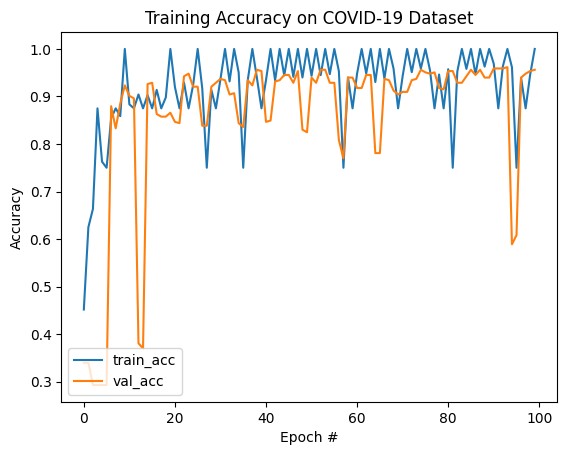

In [16]:
N = EPOCHS

plt.figure()

plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

In [17]:
from numpy import loadtxt
from tensorflow.keras.models import load_model
model = load_model('/kaggle/working/my_model.h5')

In [18]:
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)


# show a nicely formatted classification report
print(classification_report(testY, predIdxs,target_names=['normal','covid','virus']))

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step
              precision    recall  f1-score   support

      normal       0.95      0.96      0.95       134
       covid       0.96      1.00      0.98       107
       virus       0.96      0.92      0.94       124

    accuracy                           0.96       365
   macro avg       0.96      0.96      0.96       365
weighted avg       0.96      0.96      0.96       365



In [19]:
score = model.evaluate(testX, testY,verbose=1)

print(score)

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 483ms/step - accuracy: 0.9742 - loss: 0.2056
[0.26622825860977173, 0.9561643600463867]


In [20]:
import itertools
pred_Y = model.predict(testX, batch_size = 8, verbose = True)
pred_Y

46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step


array([[9.9999970e-01, 3.6178407e-29, 2.5359606e-07],
       [9.9999994e-01, 3.6485468e-33, 3.1155377e-08],
       [4.6257513e-23, 9.9999994e-01, 1.0383107e-20],
       ...,
       [8.8442522e-01, 4.9651419e-05, 1.1552511e-01],
       [1.0000000e+00, 0.0000000e+00, 1.1073414e-17],
       [8.1907119e-06, 2.8253002e-17, 9.9999177e-01]], dtype=float32)

46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step


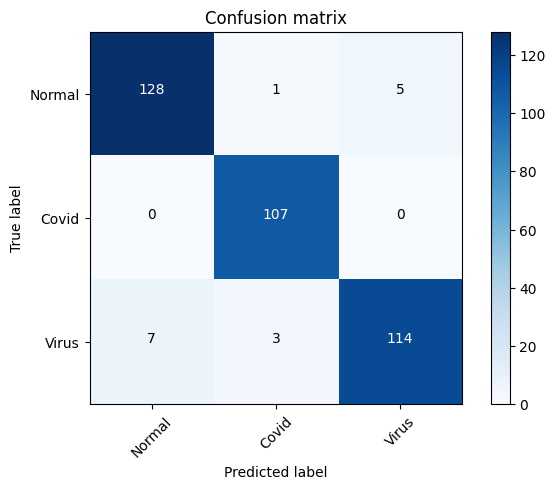

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    target_names =['Normal','Covid','Virus']

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(testX, batch_size=BS)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred_Y,axis = 1) 
# Convert validation observations to one hot vectors
# compute the confusion matrix
confusion_mtx = confusion_matrix(testY, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3)) 

In [22]:
import seaborn as sns
import pandas as pd

In [23]:
testY
y_test = pd.get_dummies(testY)
y_test = np.array(y_test)

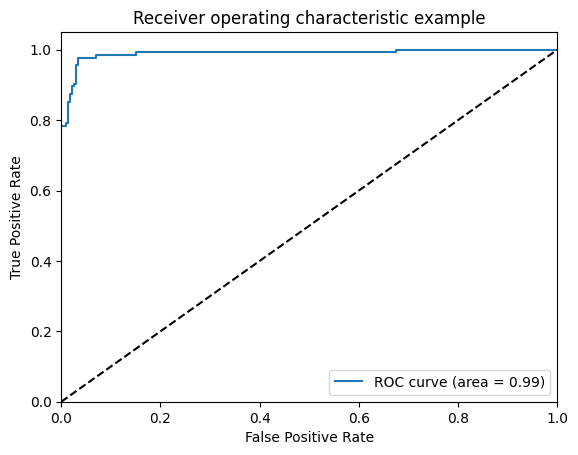

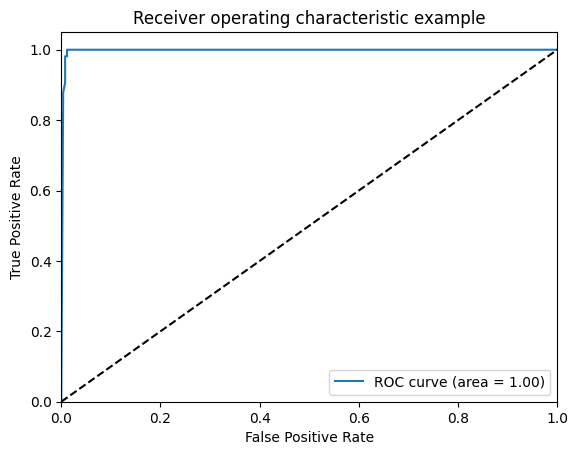

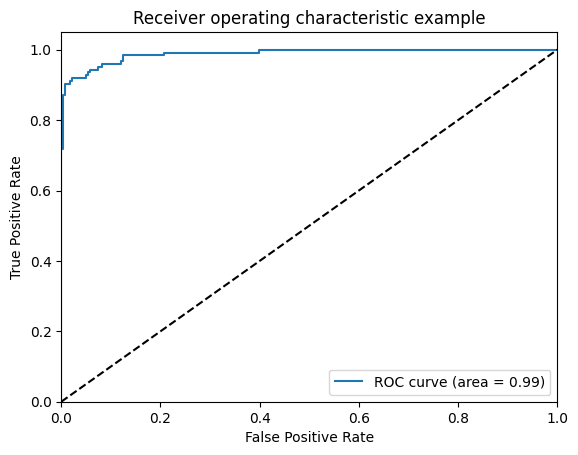

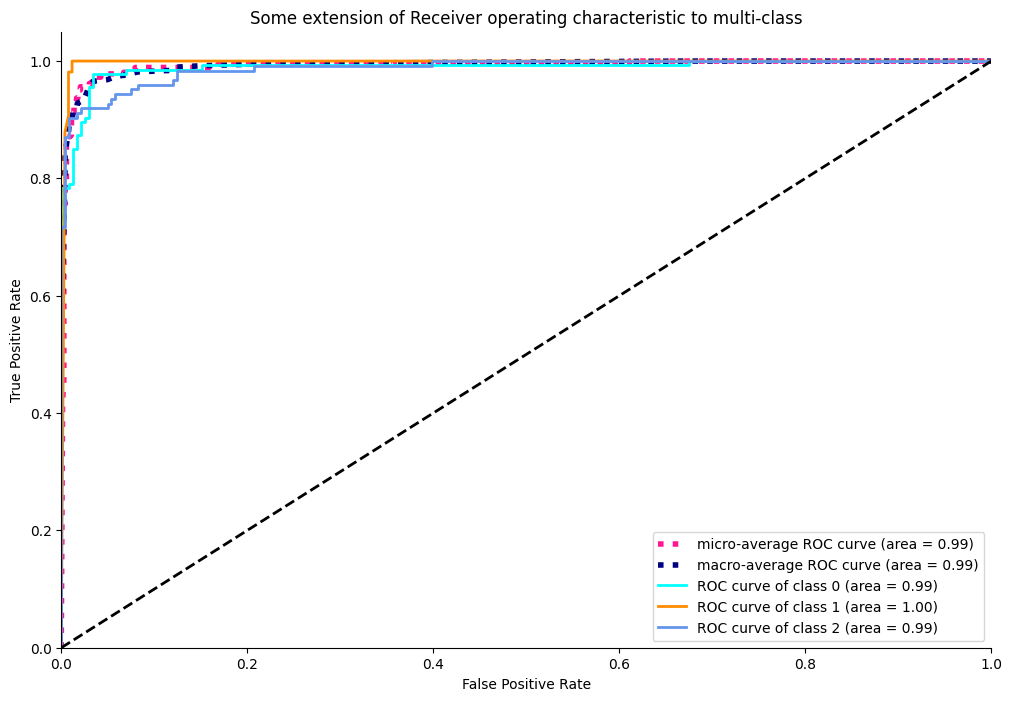

In [24]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


n_classes = 3

from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_Y[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_Y.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure(figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
sns.despine()
plt.show()

In [25]:
def specificity(y_true, y_pred):
    """
    param:
    y_pred - Predicted labels
    y_true - True labels 
    Returns:
    Specificity score
    """
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    specificity = tn / (tn + fp + K.epsilon())
    return specificity

In [26]:
specificity(y_test, Y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=0.9675803406566295>